<a href="https://colab.research.google.com/github/yifueve/EV_battery_calculator/blob/main/BETs_emissions_and_costing_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Last updates: December 3, 2023
### **Workflow for the analysis of long-haul truck electrification**

The workflow consists of 3 main steps: energy consumption, emissions analysis and costing.

1. **Energy consumption**: using real-world drive cycle data and a physics-based  vehicle model, estimate fuel economy and battery energy capacity
2. **Payload penalty**: Calculate payload losses of battery electric vehicles given the payload distribution of conventional diesel (dataset from VIUS 2002).
The output is a payload penalty factor that is equivalent to the number of additional electric trucks needed to deliver the same amount of goods.
3. **Emissions analysis**: Estimate Well-to-Wheel (WTW) emissions from fuel economy and US. grid carbon intensity
4. **Cost analysis**: Calculate of purchasing and operating a battery electric truck

Note: The default values used for this analysis are for a class 8 long-haul truck driving an average of 600 miles per day over flexible routes.

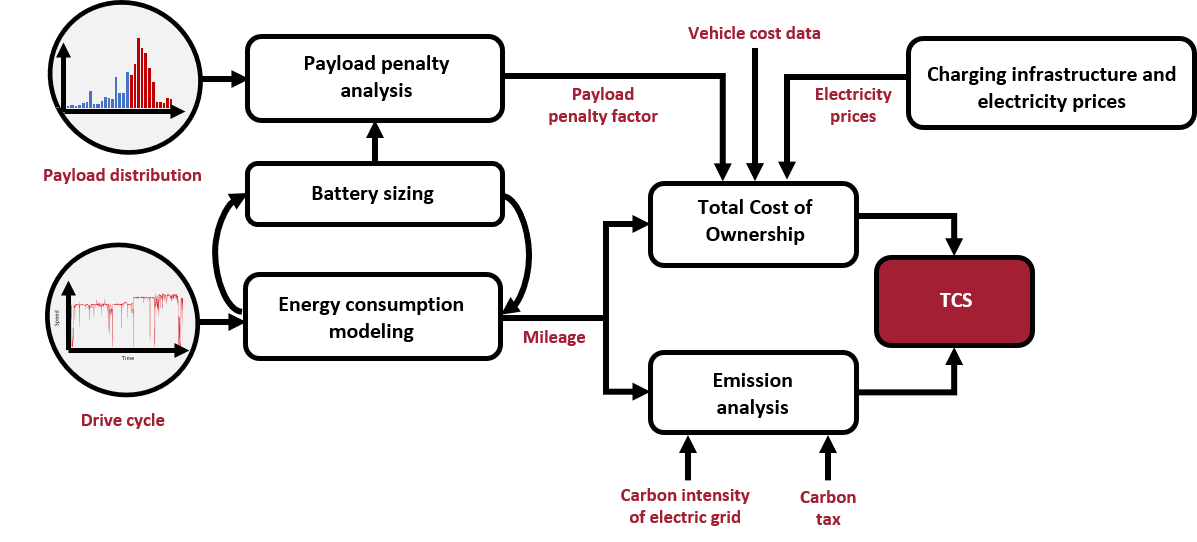

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import scipy as scipy
from scipy import integrate
import os, io
import matplotlib.pyplot as plt

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)
from google.colab import files
from scipy.optimize import curve_fit
from operator import add

# **Download examples of input files**

1.   Drive cycle. Source: Jones, R et al. (2023). Developing and Benchmarking a US Long-haul Drive Cycle forVehicle Simulations, Costing and Emissions Analysis
https://docs.google.com/spreadsheets/d/1Q2uO-JHfwvGxir_PU8IO5zmo0vs4ooC_/edit?usp=sharing&ouid=102742490305620802920&rtpof=true&sd=true
2.   Payload dataset filtered and cleaned by authors for this analysis. Source: 2002 Economic Census: Vehicle Inventory and Use Survey
https://docs.google.com/spreadsheets/d/1Oe_jBIUb-kJ5yy9vkwaPgldVe4cloAtG/edit?usp=sharing&ouid=102742490305620802920&rtpof=true&sd=true





# **Define input parameters**
Default parameters are for long-haul truckings under flexible routes with daily range of 600 miles

In [ ]:
#Parameters for vehicle simulation

m_ave_payload=41473*0.453592 #average payload +trailer mass in kg (41473 lbs, same as average payload from VIUS 2002)
m_max = 36287.39 #maximum gross vehicle weight (GVW) of 80k pounds (36287.39 kg)
m_truck_no_bat=(19500-3500-500-550+880)*0.453592 #weight of truck tractor without battery, payload and trailer in kg
                                                          #3500 lbs is engine weight (https://pubs.acs.org/doi/suppl/10.1021/acs.est.1c01273/suppl_file/es1c01273_si_001.pdf)
                                                          #https://www.energy.gov/eere/vehicles/fact-620-april-26-2010-class-8-truck-tractor-weight-component
                                                          #500 lbs is fuel system (https://pubs.acs.org/doi/suppl/10.1021/acs.est.1c01273/suppl_file/es1c01273_si_001.pdf)
                                                          #550 lbs is emission control system (https://pubs.acs.org/doi/suppl/10.1021/acs.est.1c01273/suppl_file/es1c01273_si_001.pdf)
                                                          #880 lbs is the motor, invert, electronics (https://www.transportenvironment.org/wp-content/uploads/2021/07/20180725_T&E_Battery_Electric_Trucks_EU_FINAL.pdf)

m_guess = m_ave_payload + m_truck_no_bat #truck without battery + with average payload (kg)
p_aux=10*1000 #auxiliary power in W
p_motor_max=425000 #Maximum power at the motor in W

cd = 0.6 #drag coefficient (0.6)
cr = 0.007 # resistance coefficient
a_cabin = 9.2 #frontal area cabin in m2
g=9.81 #gravity in m/s2
rho_air = 1.2 #air density in kg/m3
DoD=0.8 #Depth of discharge

eta_i = 0.95 #inverter efficiency
eta_m = 0.9 #motor efficiency
eta_gs = 0.97 #gear efficiency
eta_rb=0.80 #efficiency in regenerative braking (0.8), which includes efficiencies of all components in reverse direction (motor_to_wheels) and battery


#Parameters for emission analysis
eta_grid_transmission=0.95
VMT=np.array([108000,120000,114000,105000,92000,81000,74000,67000,59000,52000]) #Vehicle miles traveled per year. Source: Burnham, A et al. (2021)
discountrate=0.07 #discount rate


####***Passing input parameters to all classes****####

class share_parameters:
  def __init__(self,m_ave_payload, m_max, m_truck_no_bat, m_guess, p_aux, p_motor_max, cd, cr, a_cabin, g, rho_air, DoD, eta_i, eta_m, eta_gs, eta_rb, eta_grid_transmission, VMT, discountrate):

    self.m_ave_payload=m_ave_payload
    self.m_max = m_max
    self.m_truck_no_bat=m_truck_no_bat
    self.m_guess=m_guess
    self.p_aux=p_aux
    self.p_motor_max=p_motor_max

    self.cd = cd
    self.cr = cr
    self.a_cabin = a_cabin
    self.g = g
    self.rho_air = rho_air
    self.DoD = DoD

    self.eta_i = eta_i
    self.eta_m = eta_m
    self.eta_gs = eta_gs
    self.eta_rb = eta_rb
    self.eta_grid_transmission = eta_grid_transmission


    self.VMT = VMT
    self.discountrate=discountrate


# **1. Vehicle model for energy consumption**

**[Upload files:] Drive cycle for US long haul trucks**

In [ ]:
#upload drive cycle as an excel file (takes ~20s)
uploadedcycle = files.upload()

Saving drivecycle.xlsx to drivecycle.xlsx


In [ ]:
#extract vehicle speed, and road grade from drive cycle
df = pd.read_excel(io.BytesIO(uploadedcycle[list(uploadedcycle.keys())[0]])) #drive cycle as a dataframe
df['Vehicle speed (m/s)'] = df['Vehicle speed (km/h)']*1000/3600 #vehicle speed converted from km/h to m/s
df = df.drop(['Vehicle speed (km/h)'],axis=1) #remove column with vehicle speed in km/h
df['Acceleration (m/s2)'] = df['Vehicle speed (m/s)'].diff()/df['Time (s)'].diff() #calculate acceleration in m/s2
df['Acceleration (m/s2)'] = df['Acceleration (m/s2)'].fillna(0) #first data point as NaN, we replace with zero
df['Road angle'] = df['Road grade (%)'].apply(lambda x: np.arctan(x / 100)) #convert road grade to road angle RG=100 tan(road angle)
df['Cumulative distance (m)']= integrate.cumtrapz(df['Vehicle speed (m/s)'],df['Time (s)'], initial=0)

df.head() #Print out the first columns of the dataframe

,Time (s),Road grade (%),Vehicle speed (m/s),Acceleration (m/s2),Road angle,Cumulative distance (m)
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.267640,0.000000,0.000000,0.002676,0.000000
2,2,0.714901,1.425781,1.425781,0.007149,0.712890
3,3,1.528891,2.386067,0.960286,0.015288,2.618814
4,4,2.798853,2.715928,0.329861,0.027981,5.169811


In [ ]:
####**** Vehicle model and battery size****####

class truck_model:
  def __init__(self, parameters):
    self.parameters = parameters


  ##Inputs: dataframe df with drive cycle data, eta_battery--->battery efficiency (#), m---> total truck mass (kg)
  ##outputs: e_bat--->battery energy capacity in kWh, fuel_consumption--->fuel consumption in kWh/mi, df ---> updated dataframe with the new variables (e.g. simulated vehicle speed)
  def get_power_requirement(self, df, m, eta_battery):
    v_drive_cycle = df['Vehicle speed (m/s)'].shift(-1)
    road_angle = df['Road angle']
    delta_t = df['Time (s)'].diff().fillna(0) #calculate time steps (delta time= 1 seconds for the US long haul drive cycle used). first data point Na is filled with zero
    simulated_vehicle_speed, power_request_motor= [0],[] #initialize variables for simulated vehicle speed as motor is limited to deliver 425kW

    for i in range(len(v_drive_cycle)-1):
      target_acceleration = v_drive_cycle[i] - simulated_vehicle_speed[i] #required acceleration to match drive cycle in terms of vehicle speed
      fr = m*self.parameters.g*self.parameters.cr*np.cos(road_angle[i]) #force from rolling resistance in N
      fg = m*self.parameters.g*np.sin(road_angle[i]) #force from gravitational in N
      fd = self.parameters.rho_air*self.parameters.a_cabin*self.parameters.cd*np.power(simulated_vehicle_speed[i],2)/2 #force from aerodynamic drag in N
      maximum_acceleration = ((self.parameters.p_motor_max*self.parameters.eta_i*self.parameters.eta_m*self.parameters.eta_gs/simulated_vehicle_speed[i]) - fr - fg - fd)/m if simulated_vehicle_speed[i] >0 else 1e9

      a=min(target_acceleration,maximum_acceleration) #minimum acceleration between target acceleration to follow drive cycle versus maximum acceleration of truck at Pmax
      simulated_vehicle_speed.append(simulated_vehicle_speed[i]+a*delta_t[i]) #update vehicle speed for next iteration

      fa=m*a
      power_request_wheels= (fr + fg + fd + fa)* simulated_vehicle_speed[i] #total power request at the wheels in W
      power_request_motor.append(self.parameters.eta_rb*power_request_wheels if power_request_wheels<0 else power_request_wheels/(self.parameters.eta_i*self.parameters.eta_m*self.parameters.eta_gs)) #total power request at the motor in W


    ####****battery energy capacity****####
    power_request_motor.append(0)
    df['Simulated vehicle speed (m/s)'] = simulated_vehicle_speed
    df['Power request at the motor (W)'] = power_request_motor
    df['Power request at battery (W)'] = df['Power request at the motor (W)'].apply(lambda x: np.where (x<0, x+(self.parameters.p_aux/eta_battery),(x+self.parameters.p_aux)/eta_battery))
    df['Power request at battery (W)'] = df['Power request at battery (W)'].apply(lambda x: np.where (x<-self.parameters.p_motor_max, -self.parameters.p_motor_max, x)) #regenerative braking constrained to maximum power that motor can receive

    e_bat = np.trapz(df['Power request at battery (W)'],df['Time (s)'])*2.7778*np.float_power(10,-7)/self.parameters.DoD #energy of tractive battery in kWh
    fuel_consumption = np.trapz(df['Power request at battery (W)'],df['Time (s)'])*2.7778*np.float_power(10,-7)/(np.trapz(df['Simulated vehicle speed (m/s)'],df['Time (s)'])/(1.609344*1000)) #energy consumption in kWh/mile

    return df, e_bat, fuel_consumption


  ####****Battery size for trucks carring average payload****####
  ##Inputs: parameters in self, and dataframe with drive cycle
  ##outputs: m_bat--->calculated baattery mass in kg,e_bat--->battery energy capacity in kWh, mileage--->fuel consumption in kWh/mi, m-->Gross vehicle weight in kg
  def get_battery_size(self, df, eta_battery, e_density):
    m_guess=self.parameters.m_guess
    convergence = 0.45 #convergence criteria 1 lbs (0.45 kg)
    epsilon = 2 #initial value for convergence to enter loop

    while epsilon > convergence: #convergence loop for battery weight
      df, e_bat, mileage = truck_model(parameters).get_power_requirement(df, m_guess, eta_battery)
      m_bat = e_bat*1000/e_density;  #battery weight in kg
      m = m_bat + self.parameters.m_ave_payload + self.parameters.m_truck_no_bat #m is the Gross Vehicle Weight (GVW) in kg
      epsilon = abs(m - m_guess)
      m_guess = m
    if m > self.parameters.m_max: #case where the GVW exceeds the limit of 80k pounds
      print('Maximum total truck mass (80000 lbs) exceeded')
      m = self.parameters.m_max #GVW=80k pounds
      df, e_bat, mileage = truck_model(parameters).get_power_requirement(df, m, eta_battery)
      m_bat = e_bat*1000/e_density;  #battery weight in kg


    return m_bat, e_bat, mileage, m

# **2. Payload penalty analysis**


**[Upload files:] Payload distribution of long-haul trucks in the US**

In [ ]:
#upload distribution of payloads as an excel file (takes ~10s)
uploadedpayload = files.upload()

Saving payloaddistribution.xlsx to payloaddistribution.xlsx


In [ ]:
#extract payload distribution from excel file
payload_distribution = pd.read_excel(io.BytesIO(uploadedpayload[list(uploadedpayload.keys())[0]]))
payload_distribution['Payload (kg)'] = payload_distribution['Payload (lb)']*0.453592 #payload distribution in kgs
payload_distribution.head()

,Payload (lb),Payload (kg)
0,3000,1360.7760
1,3000,1360.7760
2,2200,997.9024
3,3000,1360.7760
4,3000,1360.7760


In [ ]:
####****Input parameters for payload penalty analysis****####
class payload:
  def __init__(self, parameters):
    self.parameters = parameters

##Inputs: m_bat--> battery mass in kg from truck model analysis, payload_distribution ---> database of payload distributions in the US (VIUS data 2002), self--> parameters, alpha --> parameter range from 0 to 2, base case =1
##Output: payload_Penalty --> penalty factor (number of additional trucks to be equivalent with diesel)

  def get_penalty(self, payload_distribution, m_bat, alpha):
    payload_max = self.parameters.m_max- m_bat- self.parameters.m_truck_no_bat #payload+trailer
    payload_distribution['Payload loss (kg)'] = payload_distribution['Payload (kg)'].apply(lambda x: np.maximum(x-payload_max,0))
    payload_penalty = 1 + (alpha*payload_distribution['Payload loss (kg)'].mean())/payload_max
    return payload_penalty

In [ ]:
parameters = share_parameters(m_ave_payload, m_max, m_truck_no_bat, m_guess, p_aux, p_motor_max, cd, cr, a_cabin, g, rho_air, DoD, eta_i, eta_m, eta_gs, eta_rb, eta_grid_transmission, VMT, discountrate)

**Case analysis**

In [ ]:
#Define variables for case analysis:

e_density_list_LFP=[170, 230, 330] #energy density (kWh/ton)
eta_battery_LFP=0.95 #efficiency for LFP
alpha=1; #for payload penalty factor calculations (alpha = 1 for base case, alpha = 2: complete dependency in payload measurements)

#######################################################################################################

vehicle_model_results_LFP = pd.DataFrame(columns = ['Energy battery (kWh)', 'Battery mass (lbs)', 'Fuel economy (kWh/mi)', 'Payload penalty factor', 'Total vehicle mass (lbs)'])

for e_density in e_density_list_LFP:
  m_bat, e_bat, mileage, m= truck_model(parameters).get_battery_size(df, eta_battery_LFP, e_density)
  payload_penalty_factor=payload(parameters).get_penalty(payload_distribution, m_bat, alpha)
  vehicle_model_results_LFP.loc[len(vehicle_model_results_LFP)] = [e_bat, m_bat/0.453592, mileage, payload_penalty_factor, m/0.453592]

vehicle_model_results_LFP.head()

Maximum total truck mass (80000 lbs) exceeded


,Energy battery (kWh),Battery mass (lbs),Fuel economy (kWh/mi),Payload penalty factor,Total vehicle mass (lbs)
0,2284.578536,29627.280178,3.048151,1.273074,80000.066139
1,2270.870741,21767.030830,3.029653,1.093551,79070.030830
2,2162.145473,14444.602148,2.883468,1.019688,71747.602148


In [ ]:
#Define variables for case analysis:

e_density_list_NMC=[260, 350, 500] #energy density (kWh/ton)
eta_battery_NMC=0.93 #efficiency for LFP
alpha=1; #for payload penalty factor calculations (alpha = 1 for base case, alpha = 2: complete dependency in payload measurements)

#######################################################################################################

vehicle_model_results_NMC = pd.DataFrame(columns = ['Energy battery (kWh)', 'Battery mass (lbs)', 'Fuel economy (kWh/mi)', 'Payload penalty factor', 'Total vehicle mass (lbs)'])

for e_density in e_density_list_NMC:
  m_bat, e_bat, mileage, m= truck_model(parameters).get_battery_size(df, eta_battery_NMC, e_density)
  payload_penalty_factor=payload(parameters).get_penalty(payload_distribution, m_bat, alpha)
  vehicle_model_results_NMC.loc[len(vehicle_model_results_NMC)] = [e_bat, m_bat/0.453592, mileage, payload_penalty_factor, m/0.453592]

vehicle_model_results_NMC.head()

,Energy battery (kWh),Battery mass (lbs),Fuel economy (kWh/mi),Payload penalty factor,Total vehicle mass (lbs)
0,2286.137221,19384.899786,3.049544,1.059654,76687.899786
1,2202.149750,13871.180330,2.936758,1.017130,71174.180330
2,2133.869963,9408.763660,2.845352,1.006362,66711.763660


# **3. Emissions analysis**

In [ ]:
##Evolution of carbon intensities for US electric grid.
##Carbon intensities from EIA for every five years and fitted to a exponential decay curve
carbon_intensity_EIA=np.array([370, 388, 314, 183, 163, 153, 146, 135])
timeline=np.array([2020, 2021, 2025, 2030, 2035, 2040, 2045, 2050])

def mono_exp(x,a,b,c): #exponential decay curve
  return a*np.exp(-b*x)+c

params,cov=curve_fit(mono_exp, timeline, carbon_intensity_EIA, [1000000,0.003, 0.1],maxfev=50000000) #fit data to exponential decay curve


def CI_grid_cal(timeline):
  carbon_intensity_calc= mono_exp(timeline,params[0],params[1],params[2])
  return carbon_intensity_calc

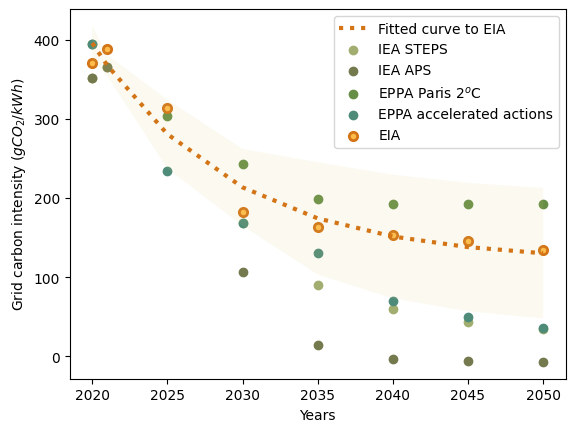

In [ ]:
#Carbon emissions intensity of the US grid over time from various models and policy scenarios, and fitted curve from EIA data

data_CI=[
 {2020:352, 2021: 365, 2025: np.nan,2030: 168, 2035:90, 2040:60, 2045:44, 2050:34}, ##IEA STEPS
 {2020:352, 2021: 365, 2025: np.nan, 2030: 107, 2035: 15, 2040: -3, 2045:-6, 2050:-7}, ##IEA APS
 {2020:395, 2021: np.nan, 2025: 304, 2030:243, 2035:199, 2040:193, 2045:192, 2050:192}, #EPPA Paris 2C scenario
 {2020:395, 2021: np.nan, 2025:234, 2030:168, 2035:130, 2040:70, 2045:50, 2050:36}, ##EPPA Accelerated actions
  {2020: 370, 2021: 388, 2025: 314, 2030: 183, 2035:163, 2040: 153, 2045:146, 2050:135} ##EIA
          ]
CI=pd.DataFrame(data_CI, index=['IEA STEPS', 'IEA APS','EPPA Paris 2C', 'EPPA Accelerated', 'EIA'])
carbon_intensity_calc=CI_grid_cal(timeline)

##plots
plt.plot(timeline, carbon_intensity_calc, ':',linewidth=3, color='#D37416', label='Fitted curve to EIA'), plt.xlabel('Years'), plt.ylabel('Grid carbon intensity ($gCO_2/kWh$)')
plt.scatter(*zip(*sorted(data_CI[0].items())), color='#A1AE6F', marker="o", label='IEA STEPS')
plt.scatter(*zip(*sorted(data_CI[1].items())), color='#75794E', marker="o", label='IEA APS')
plt.scatter(*zip(*sorted(data_CI[2].items())), color='#678E47', marker="o", label='EPPA Paris $2^o$C')
plt.scatter(*zip(*sorted(data_CI[3].items())), color='#4E8B78', marker="o", label='EPPA accelerated actions')
plt.scatter(*zip(*sorted(data_CI[4].items())), color='#FFBC4A', marker="o", edgecolor='#D37416', linewidth=2, label='EIA')

plt.fill_between(timeline, carbon_intensity_calc-CI.std(), carbon_intensity_calc+CI.std(),alpha=0.1, facecolor='#DACC75')
plt.legend()
plt.savefig('Grid_carbon_intensity.svg')
plt.show()

In [ ]:
####****Emissions analysis****####
class emission:
  def __init__(self, parameters):
    self.parameters = parameters

##Inputs: GHG battery manufacturing (GHG_bat_unit, g CO2/kWh), number of replacements (replacements), vehicle model results
##Output: GHGs emissions (gCO2/mi), Well to Wheel. We did not consider other emissions like PM2.5

  def get_WTW(self, vehicle_model_results, GHG_bat_unit, replacements):
    GHG_emissions = pd.DataFrame(columns = ['GHGs manufacturing (gCO2/mi)', 'GHGs grid (gCO2/mi)', 'GHGs total (gCO2/mi)'])
    GHG_emissions['GHGs manufacturing (gCO2/mi)'] = (vehicle_model_results['Payload penalty factor']*(1+ replacements)*vehicle_model_results['Energy battery (kWh)']*GHG_bat_unit)/self.parameters.VMT.sum()

    CI_grid_miles = pd.DataFrame({'CI_grid_miles':[sum(xi * yi for xi, yi in zip(self.parameters.VMT, y)) for y in [CI_grid_cal(range(2020,2030)), CI_grid_cal(range(2030,2040)), CI_grid_cal(range(2050,2060))]]})
    GHG_emissions['GHGs grid (gCO2/mi)']=vehicle_model_results['Payload penalty factor']*vehicle_model_results['Fuel economy (kWh/mi)']*CI_grid_miles['CI_grid_miles']/(self.parameters.eta_grid_transmission*self.parameters.VMT.sum())
    GHG_emissions['GHGs total (gCO2/mi)'] =  GHG_emissions['GHGs manufacturing (gCO2/mi)'] + GHG_emissions['GHGs grid (gCO2/mi)'] # WTW emissions
    return GHG_emissions # in gCO2/mi

**Case analysis**

In [ ]:
#Define variables for case analysis:

GHG_bat_unit_LFP=69*1000 #g CO2/kWh
replacements_LFP=0

#######################################################################################################
GHG_emissions_LFP= emission(parameters).get_WTW(vehicle_model_results_LFP, GHG_bat_unit_LFP,  replacements_LFP)
GHG_emissions_LFP.head()

,GHGs manufacturing (gCO2/mi),GHGs grid (gCO2/mi),GHGs total (gCO2/mi)
0,230.140135,1272.201237,1502.341372
1,196.500594,644.442499,840.943093
2,174.455604,392.844670,567.300275


In [ ]:
#Define variables for case analysis:

GHG_bat_unit_NMC=86*1000 #g CO2/kWh
replacements_NMC=1

#######################################################################################################

GHG_emissions_NMC= emission(parameters).get_WTW(vehicle_model_results_NMC, GHG_bat_unit_NMC,  replacements_NMC)
GHG_emissions_NMC.head()

,GHGs manufacturing (gCO2/mi),GHGs grid (gCO2/mi),GHGs total (gCO2/mi)
0,477.835539,1059.411675,1537.247214
1,441.809865,581.028199,1022.838064
2,423.578722,382.585435,806.164157


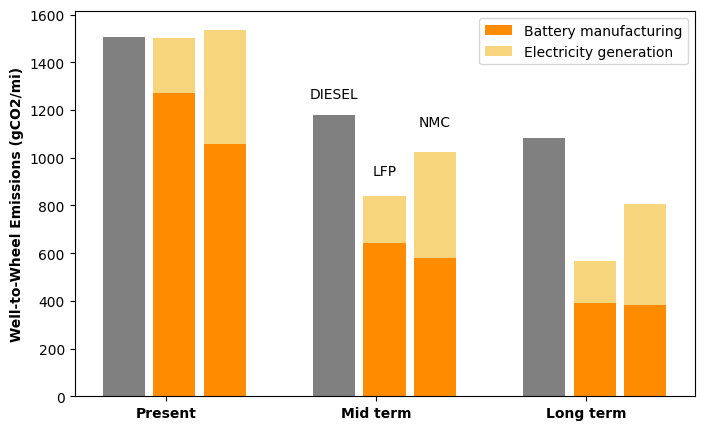

In [ ]:
############# Plot results ##########################

##GHGs emissions for diesel baseline:
GHG_emissions_diesel = pd.DataFrame({'Diesel Baseline (gCO2/mi)': [1507, 1180, 1081]}) # in gCO2/mi Source: Jones, R et al. (2023).Developing and Benchmarking a US Long-haul Drive Cycle forVehicle Simulations, Costing and Emissions Analysis.
GHG_emissions_diesel.head()


#plots
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.2


bar1 = np.arange(len(GHG_emissions_LFP.index))
bar2 = [x + 1.2*bar_width for x in bar1]
bar3 = [x + 1.2*bar_width for x in bar2]


ax.bar(bar1,[0,0,0], width=bar_width, color='darkorange')
ax.bar(bar2, GHG_emissions_LFP['GHGs grid (gCO2/mi)'], label='Battery manufacturing', width=bar_width, color='darkorange')
ax.bar(bar3, GHG_emissions_NMC['GHGs grid (gCO2/mi)'], width=bar_width, color='darkorange')


plt1=ax.bar(bar1, GHG_emissions_diesel['Diesel Baseline (gCO2/mi)'], width=bar_width, bottom=[0,0,0], color='gray')
plt2=ax.bar(bar2, GHG_emissions_LFP['GHGs manufacturing (gCO2/mi)'], width=bar_width, label='Electricity generation',  bottom= GHG_emissions_LFP['GHGs grid (gCO2/mi)'], color='#F7D57D')
plt3=ax.bar(bar3, GHG_emissions_NMC['GHGs manufacturing (gCO2/mi)'], width=bar_width, bottom= GHG_emissions_NMC['GHGs grid (gCO2/mi)'], color='#F7D57D')


plt.text(bar1[1], 1.2*plt1[-1].get_height(), 'DIESEL', ha='center', va='top')
plt.text(bar2[1], 0.9*plt1[-1].get_height(), 'LFP', ha='center', va='top')
plt.text(bar3[1], plt1[-2].get_height(), 'NMC', ha='center', va='top')


ax.set_ylabel('Well-to-Wheel Emissions (gCO2/mi)', weight='bold')
ax.set_xticks([r + bar_width for r in range(len(GHG_emissions_LFP.index))])
ax.set_xticklabels(['Present', 'Mid term', 'Long term'],weight='bold')
ax.legend(loc='upper right')


plt.show()

# **4. Costing analysis**

In [ ]:
####****Cost analysis****####
#TCSs (in $ per vehicle mile travelled) are given in the corresponding present values of each scenario today, 2030 and 2050

#Inputs: Vehicle model results, number of replacements, capital and operating unit costs, GHG emissions, social cost of carbon and discount dactor
#Output: TCS, total operating costs per mile, total capital costs per mile, GHGs emissions penalty per mile


class cost:
  def __init__(self, parameters):
    self.parameters = parameters


  def get_capital(self, vehicle_model_results, replacements, capital_cost_unit,battery_unit_cost,discountfactor):
    #We consider replacement of NMC battery in the 5th year of truck's lifetime
    capital = capital_cost_unit['glider ($)'] + (capital_cost_unit['motor and inverter ($/kW)']*self.parameters.p_motor_max/1000) + (capital_cost_unit['DC-DC converter ($/kW)']*self.parameters.p_aux/1000) + ((1+(replacements*discountfactor[5]))*(battery_unit_cost*vehicle_model_results['Energy battery (kWh)']))
    total_CAPEX= vehicle_model_results['Payload penalty factor']*capital/self.parameters.VMT.sum()
    return total_CAPEX #in $ per mile

  def get_operating(self, vehicle_model_results, replacements, operating_cost_unit, electricity_unit, total_CAPEX,discountfactor):
    electricity = vehicle_model_results['Payload penalty factor']* electricity_unit*vehicle_model_results['Fuel economy (kWh/mi)']*np.sum(self.parameters.VMT* discountfactor)/self.parameters.VMT.sum()
    labor = vehicle_model_results['Payload penalty factor']* operating_cost_unit['labor ($/mi)']*np.sum(self.parameters.VMT* discountfactor)/self.parameters.VMT.sum()
    others_opex = vehicle_model_results['Payload penalty factor']*(operating_cost_unit['maintenance & repair ($/mi)']+ operating_cost_unit['misc ($/mi)'] + (operating_cost_unit['insurance ($/mi)']*total_CAPEX/vehicle_model_results['Payload penalty factor']))*np.sum(self.parameters.VMT* discountfactor)/self.parameters.VMT.sum()
    total_OPEX=  electricity + labor + others_opex
    return total_OPEX, electricity, labor, others_opex  #in $ per mile

  def get_penalty_emissions(self, GHG_emissions, SCC):
    #Given that future SCC are quite uncertain and that SCC are already in present value, we did not apply discounted cash flow for this cost component
    penalty_emissions= GHG_emissions*SCC/1000000
    return penalty_emissions #in $ per mile

  def get_TCS(self, vehicle_model_results, capital_cost_unit, battery_unit_cost, operating_cost_unit, electricity_unit, replacements, GHG_emissions, SCC):
    costs_total = pd.DataFrame(columns = ['Total capital ($/mi)', 'Total operating ($/mi)', 'Total electricity ($/mi)', 'Total labor ($/mi)', 'Other OPEXs ($/mi)', 'GHGs emissions penalty ($/mi)', 'TCS ($/mi)'])

    discountfactor=1/np.power(1+self.parameters.discountrate,np.linspace(0,9,10)) #life time of trucks is 10 years
    costs_total['Total capital ($/mi)']= cost(parameters).get_capital(vehicle_model_results, replacements, capital_cost_unit,battery_unit_cost, discountfactor)
    costs_total[ 'Total operating ($/mi)'], costs_total['Total electricity ($/mi)'], costs_total['Total labor ($/mi)'], costs_total['Other OPEXs ($/mi)']= cost(parameters).get_operating(vehicle_model_results, replacements, operating_cost_unit, electricity_unit, costs_total['Total capital ($/mi)'],discountfactor)
    costs_total['GHGs emissions penalty ($/mi)'] = cost(parameters).get_penalty_emissions(GHG_emissions['GHGs total (gCO2/mi)'], SCC)
    costs_total['TCS ($/mi)'] = costs_total['Total capital ($/mi)'] + costs_total[ 'Total operating ($/mi)'] + costs_total['GHGs emissions penalty ($/mi)']
    return costs_total #in $ per mile


In [ ]:
####****Input parameters for capital and operating unit costs****####

# Motor and inverter cost is given per unit of drivetrain power rating (Motor peak power)
# DC-DC converter cost is given per unit of auxiliary power rating  (Auxiliary loads)
# Insurance cost is per unit of capital cost of a single BET (no payload penalty included). We computed from reported insurance cost (0.1969 $/mi) for a BET vehicle cost (0.9933 $/mi). Source: https://publications.anl.gov/anlpubs/2021/05/167399.pdf
# Glider cost from Jones, R et al. (2023). Developing and Benchmarking a US Long-haul Drive Cycle forVehicle Simulations, Costing and Emissions Analysis


capital_cost_unit= pd.DataFrame({'glider ($)': [95000, 95000, 95000], 'motor and inverter ($/kW)': [77, 25, 18], 'DC-DC converter ($/kW)': [90, 65, 65]})
operating_cost_unit = pd.DataFrame({'maintenance & repair ($/mi)': [0.14, 0.14, 0.14], 'labor ($/mi)': [0.69, 0.69, 0.69], 'insurance ($/mi)': [0.19822813, 0.19822813, 0.19822813], 'misc ($/mi)': [0.05,0.05,0.05]})

**Case analysis**

In [ ]:
####****Input parameters for case analysis****####
electricity_unit=[0.32, 0.32, 0.15];
SCC=[51, 62, 85] #social cost of carbon in $/ton CO2. Source: https://www.whitehouse.gov/wp-content/uploads/2021/02/TechnicalSupportDocument_SocialCostofCarbonMethaneNitrousOxide.pdf

battery_unit_cost_LFP=[100, 75, 70] #LFP unit cost in $/kWh
TCS_LFP=cost(parameters).get_TCS(vehicle_model_results_LFP, capital_cost_unit, battery_unit_cost_LFP, operating_cost_unit, electricity_unit, replacements_LFP, GHG_emissions_LFP, SCC)
TCS_LFP.head() #TCS in $/mi

,Total capital ($/mi),Total operating ($/mi),Total electricity ($/mi),Total labor ($/mi),Other OPEXs ($/mi),GHGs emissions penalty ($/mi),TCS ($/mi)
0,0.521322,1.942439,0.978358,0.692087,0.271994,0.076619,2.540381
1,0.346864,1.647659,0.835294,0.594492,0.217874,0.052138,2.046662
2,0.297780,1.100970,0.347481,0.554338,0.199151,0.048221,1.446970


In [ ]:
battery_unit_cost_NMC=[137, 100, 80] #NMC unit cost in $/kWh
TCS_NMC=cost(parameters).get_TCS(vehicle_model_results_NMC, capital_cost_unit, battery_unit_cost_NMC, operating_cost_unit, electricity_unit, replacements_NMC, GHG_emissions_NMC, SCC)
TCS_NMC.head() #TCS in $/mi

,Total capital ($/mi),Total operating ($/mi),Total electricity ($/mi),Total labor ($/mi),Other OPEXs ($/mi),GHGs emissions penalty ($/mi),TCS ($/mi)
0,0.808270,1.675643,0.814717,0.576064,0.284861,0.078400,2.562313
1,0.563971,1.546388,0.753100,0.552947,0.240341,0.063416,2.173775
2,0.456698,1.107475,0.338407,0.547093,0.221975,0.068524,1.632697


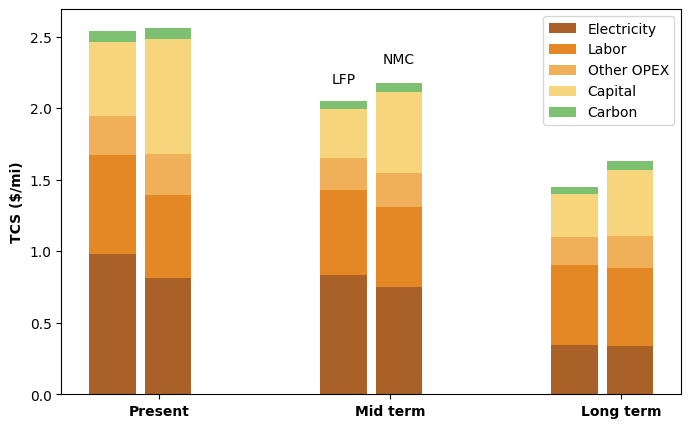

In [ ]:

#plot results
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.2


bar1 = np.arange(len(TCS_NMC.index))
bar2 = [x + 1.2*bar_width for x in bar1]


ax.bar(bar1, TCS_LFP['Total electricity ($/mi)'], label='Electricity', width=bar_width, color='#AA6127')
ax.bar(bar2, TCS_NMC['Total electricity ($/mi)'], width=bar_width, color='#AA6127')


ax.bar(bar1, TCS_LFP['Total labor ($/mi)'], width=bar_width, bottom=TCS_LFP['Total electricity ($/mi)'], color='#E48825')
ax.bar(bar2, TCS_NMC['Total labor ($/mi)'], width=bar_width, label='Labor',  bottom= TCS_NMC['Total electricity ($/mi)'], color='#E48825')

ax.bar(bar1, TCS_LFP['Other OPEXs ($/mi)'], width=bar_width, bottom=TCS_LFP['Total labor ($/mi)']+TCS_LFP['Total electricity ($/mi)'], color='#F0B05A')
ax.bar(bar2, TCS_NMC['Other OPEXs ($/mi)'], width=bar_width, label='Other OPEX',  bottom= TCS_NMC['Total labor ($/mi)']+TCS_NMC['Total electricity ($/mi)'], color='#F0B05A')

ax.bar(bar1, TCS_LFP['Total capital ($/mi)'], width=bar_width, bottom=TCS_LFP['Other OPEXs ($/mi)']+TCS_LFP['Total labor ($/mi)']+TCS_LFP['Total electricity ($/mi)'], color='#F7D57C')
ax.bar(bar2, TCS_NMC['Total capital ($/mi)'], width=bar_width, label='Capital',  bottom= TCS_NMC['Other OPEXs ($/mi)']+TCS_NMC['Total labor ($/mi)']+TCS_NMC['Total electricity ($/mi)'], color='#F7D57C')

plt1=ax.bar(bar1, TCS_LFP['GHGs emissions penalty ($/mi)'], width=bar_width, bottom=TCS_LFP['Total capital ($/mi)']+TCS_LFP['Other OPEXs ($/mi)']+TCS_LFP['Total labor ($/mi)']+TCS_LFP['Total electricity ($/mi)'], color='#7EC071')
plt2=ax.bar(bar2, TCS_NMC['GHGs emissions penalty ($/mi)'], width=bar_width, label='Carbon',  bottom= TCS_NMC['Total capital ($/mi)']+TCS_NMC['Other OPEXs ($/mi)']+TCS_NMC['Total labor ($/mi)']+TCS_NMC['Total electricity ($/mi)'], color='#7EC071')


plt.text(bar1[1], 1.1*TCS_LFP['TCS ($/mi)'][1], 'LFP', ha='center', va='top')
plt.text(bar2[1], 1.1*TCS_NMC['TCS ($/mi)'][1], 'NMC', ha='center', va='top')



ax.set_ylabel('TCS ($/mi)', weight='bold')
ax.set_xticks([r + bar_width for r in range(len(TCS_LFP.index))])
ax.set_xticklabels(['Present', 'Mid term', 'Long term'],weight='bold')
ax.legend(loc='upper right')


plt.show()